## 1. Import required libraries

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## 2. Define data generator

#### Gearbox simulator class definition, based on a system of equations determined analytically.
#### This class should be capable of simulating a gearbox under healthy or faulty conditions.
#### The required inputs include:
#### 1 - Total simulation time, total_time
#### 2 - Simulation time steps, dt
#### 3 - Location of tooth fault, fault_tooth
#### 4 - If a fault is present, faulty

In [3]:
class GearboxSimulator:
    def __init__(self, total_time=5.0, dt=5e-6, fault_tooth=5, faulty=False):
        self.dt = dt                                                        # Time step for simulation
        self.total_time = total_time                                        # Total simulation time
        self.n_steps = int(total_time / dt)                                 # Total number of steps
        self.time = np.linspace(0, total_time, self.n_steps)                # Time array
        self.faulty = faulty                                                # Gearbox state, healthy or faulty
        self.fault_tooth = fault_tooth                                      # Location of faulty tooth

        # System DOF and integration constants
        self.dof = 8                                                        # No. of Degrees of Freedom
        self.beta = 0.25                                                    # Newmark Solver, beta
        self.gamma = 0.5                                                    # Newmark Solver, gamma

        # System Parameters
        self.m_1 = 0.6                                                      # Mass of pinion [kg]
        self.m_2 = 1.5                                                      # Mass of gear [kg]
        self.I_12 = 0.00027                                                 # Inertia of pinion
        self.I_21 = 0.0027                                                  # Inertia of gear
        self.I_11 = 0.0043                                                  # Inertia of drive motor
        self.I_22 = 0.0045                                                  # Inertia of driven load
        self.k_x1 = self.k_y1 = self.k_x2 = self.k_y2 = 1e8                 # Stiffness in x/y-direction for gear/pinion
        self.k_th1 = self.k_th2 = 1e5                                       # Torsional stiffness for gear/pinion
        self.k_gm_min = 0.81e8                                              # Gear meshing stiffness (minimum)
        self.k_gm_max = 2.1e8                                               # Gear meshing stiffness (maximum)
        self.c_m = 0.05                                                     # Damping coefficient, mass
        self.c_k = 1e-6                                                     # Damping coefficient, stiffness
        self.alpha = np.deg2rad(20)                                         # Pressure angle [rad]
        self.r_pinion = 0.02819                                             # Pinion base radius [m]
        self.r_gear = 0.05638                                               # Gear base radius [m]
        self.contact_ratio = 1.6                                            # Tooth contact ratio
        self.meshing_cycle_p = 2 * np.pi / 20                               # Meshing cycle [rad]
        self.T_b = 32.0                                                     # Breakdown torque [Nm]
        self.g_b = 0.315                                                    # Motor slip constant
        self.c_a1 = 1.711                                                   # Motor constant 1
        self.c_a2 = 1.316                                                   # Motor constant 2
        self.omega_s = 1500 * (2 * np.pi / 60)                              # Synchronous speed [rpm]
        self.T_start = 27.0                                                 # Starting torque [Nm]

        # Preallocate arrays
        self.u = np.zeros((self.n_steps, self.dof))                         # System displacement
        self.v = np.zeros((self.n_steps, self.dof))                         # System velocity
        self.a = np.zeros((self.n_steps, self.dof))                         # System acceleration
        self.F_store = np.zeros((self.n_steps, self.dof))                   # Force vector
        self.k_gm_store = np.zeros(self.n_steps)                            # Gear meshing stiffness

        # Initialize system matrices
        self.M = self.mass_matrix()                                         # System mass matrix
        self.K_static = self.k_static()                                     # System static stiffness matrix
        self.S_matrix = self.s_matrix()                                     # System static geometry matrix
        self.initialize()

    def mass_matrix(self):
        m = np.zeros((8, 8))
        m[0, 0] = m[1, 1] = self.m_1
        m[2, 2] = self.I_11
        m[3, 3] = self.I_12
        m[4, 4] = m[5, 5] = self.m_2
        m[6, 6] = self.I_22
        m[7, 7] = self.I_21
        return m

    def k_static(self):
        k = np.zeros((8,8))
        k[0, 0] = self.k_x1
        k[1, 1] = self.k_y1
        k[2, 2] = self.k_th1
        k[2, 3] = -self.k_th1
        k[3, 2] = -self.k_th1
        k[3, 3] = self.k_th1
        k[4, 4] = self.k_x2
        k[5, 5] = self.k_y2
        k[6, 6] = self.k_th2
        k[6, 7] = -self.k_th2
        k[7, 6] = -self.k_th2
        k[7, 7] = self.k_th2
        return k

    def k_gm(self, theta):
        """Return the mesh stiffness for the current state, taking fault conditions into account."""
        # theta = Current rotational displacement of the pinion/gear
        if self.faulty:
            return self.k_gm_with_fault(theta)
        else:
            return self.k_gm_healthy(theta)

    def k_gm_healthy(self, theta):
        """Calculate healthy gear mesh stiffness."""
        # theta = Current rotational displacement of the pinion/gear
        theta_rel = theta % (2 * np.pi)
        cycle_idx = np.floor(theta_rel / self.meshing_cycle_p)
        theta_cycle_pos = theta_rel - (cycle_idx * self.meshing_cycle_p)
        if theta_cycle_pos < (self.meshing_cycle_p * (2 - self.contact_ratio)):
            return self.k_gm_min
        else:
            return self.k_gm_max

    def k_gm_with_fault(self, theta):
        """Calculate gear mesh stiffness considering a fault in one tooth."""
        # theta = Current rotational displacement of the pinion/gear
        theta_rel = theta % (2 * np.pi)
        n_cycles = np.floor(theta_rel / self.meshing_cycle_p)
        theta_cycle_pos = theta_rel - (n_cycles * self.meshing_cycle_p)
        if theta_cycle_pos < (self.meshing_cycle_p * (2 - self.contact_ratio)):
            k_gm = self.k_gm_min
        else:
            k_gm = self.k_gm_max
        if n_cycles == (self.fault_tooth - 1):
            k_gm *= 0.9  # Simulate local tooth damage
        return k_gm

    def s_matrix(self):
        """Compute the system stiffness matrix."""
        a, r_p, r_g = self.alpha, self.r_pinion, self.r_gear
        s3, s4, s5 = np.sin(a)**2, np.cos(a)**2, np.sin(a)*np.cos(a)
        s6, s7, s8, s9 = r_p*np.cos(a), r_p*np.sin(a), r_g*np.cos(a), r_g*np.sin(a)
        s10, s11, s12 = r_p**2, r_g**2, r_p*r_g

        return np.array([  # Structure matrix (geometry-based)
            [s3, s5, 0, s7, -s3, -s5, 0, s9],
            [s5, s4, 0, s6, -s5, -s4, 0, s8],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [s7, s6, 0, s10, -s7, -s6, 0, s12],
            [-s3, -s5, 0, -s7, s3, s5, 0, -s9],
            [-s5, -s4, 0, -s6, s5, s4, 0, -s8],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [s9, s8, 0, s12, -s9, -s8, 0, s11]
        ])

    def c_matrix(self, K):
        """Calculate the damping matrix."""
        # K = calculated "full" stiffness matrix
        return self.c_m * self.M + self.c_k * K

    def force_vector(self, omega_r):
        """Calculate the external force vector based on rotational speed."""
        # omega_r = rotational speed of the motor
        T_l = 20
        g_n = 1 - (omega_r / self.omega_s)
        T_m = self.T_b / (1 + (self.g_b - g_n)**2 * ((self.c_a1 / g_n) - self.c_a2 * g_n**2)) if np.abs(omega_r) > 1e-4 else self.T_start
        f = np.zeros(self.dof)
        f[2] = T_m  # Torque for DOF 2 (e.g., motor)
        f[6] = T_l  # Torque for DOF 6 (e.g., load)
        return f

    def k_full(self, k_gm):
        # k_gm = gear meshing stiffness at current timestep
        """Calculate the full stiffness matrix (static + dynamic component)."""
        return self.K_static + k_gm * self.S_matrix

    def initialize(self):
        """Initialize system state and perform the time-stepping integration."""
        self.k_gm_store[0] = self.k_gm(self.u[0][3])
        K = self.k_full(self.k_gm_store[0])
        C = self.c_matrix(K)
        self.F_store[0, :] = self.force_vector(self.v[0][2])
        self.a[0, :] = np.linalg.solve(self.M, self.F_store[0] - C @ self.v[0] - K @ self.u[0])

        # Time-stepping
        for i in range(1, self.n_steps):
            K = self.k_full(self.k_gm_store[i - 1])
            C = self.c_matrix(K)
            K_eff = K + self.gamma/(self.beta*self.dt)*C + 1/(self.beta*self.dt**2)*self.M

            F_eff = self.F_store[i - 1] + self.M @ (
                (1/(self.beta*self.dt**2)) * self.u[i-1] + (1/(self.beta*self.dt)) * self.v[i-1] + (1/(2*self.beta) - 1) * self.a[i-1]
            ) + C @ (
                (self.gamma/(self.beta*self.dt)) * self.u[i-1] + (self.gamma/self.beta - 1) * self.v[i-1] + self.dt*(self.gamma/(2*self.beta) - 1)*self.a[i-1]
            )

            self.u[i] = np.linalg.solve(K_eff, F_eff)
            self.a[i] = (1/(self.beta*self.dt**2)) * (self.u[i] - self.u[i-1]) - (1/(self.beta*self.dt)) * self.v[i-1] - (1/(2*self.beta) - 1) * self.a[i-1]
            self.v[i] = self.v[i-1] + self.dt * ((1 - self.gamma)*self.a[i-1] + self.gamma*self.a[i])
            self.F_store[i] = self.force_vector(self.v[i][2])
            self.k_gm_store[i] = self.k_gm(self.u[i][3])
            
        self.net_supplied_torques = self.F_store[:, 2] + self.F_store[:, 6] / 2

    def get_data(self):
        """Return the simulation data."""
        return {
            "time": self.time,
            "displacement": self.u,
            "velocity": self.v,
            "acceleration": self.a,
            "force": self.F_store,
            "gear_mesh_stiffness": self.k_gm_store,
            "net_supplied_torques": self.net_supplied_torques
        }

## 4. Example usage

#### Generate data for both healthy and fault conditions.

In [4]:
# Healthy case
healthy_sim = GearboxSimulator(faulty=False)
healthy_data = healthy_sim.get_data()

# Faulty case, fault on tooth 5
faulty_sim = GearboxSimulator(faulty=True, fault_tooth=5)
faulty_data = faulty_sim.get_data()

## 5. Plotting for validation

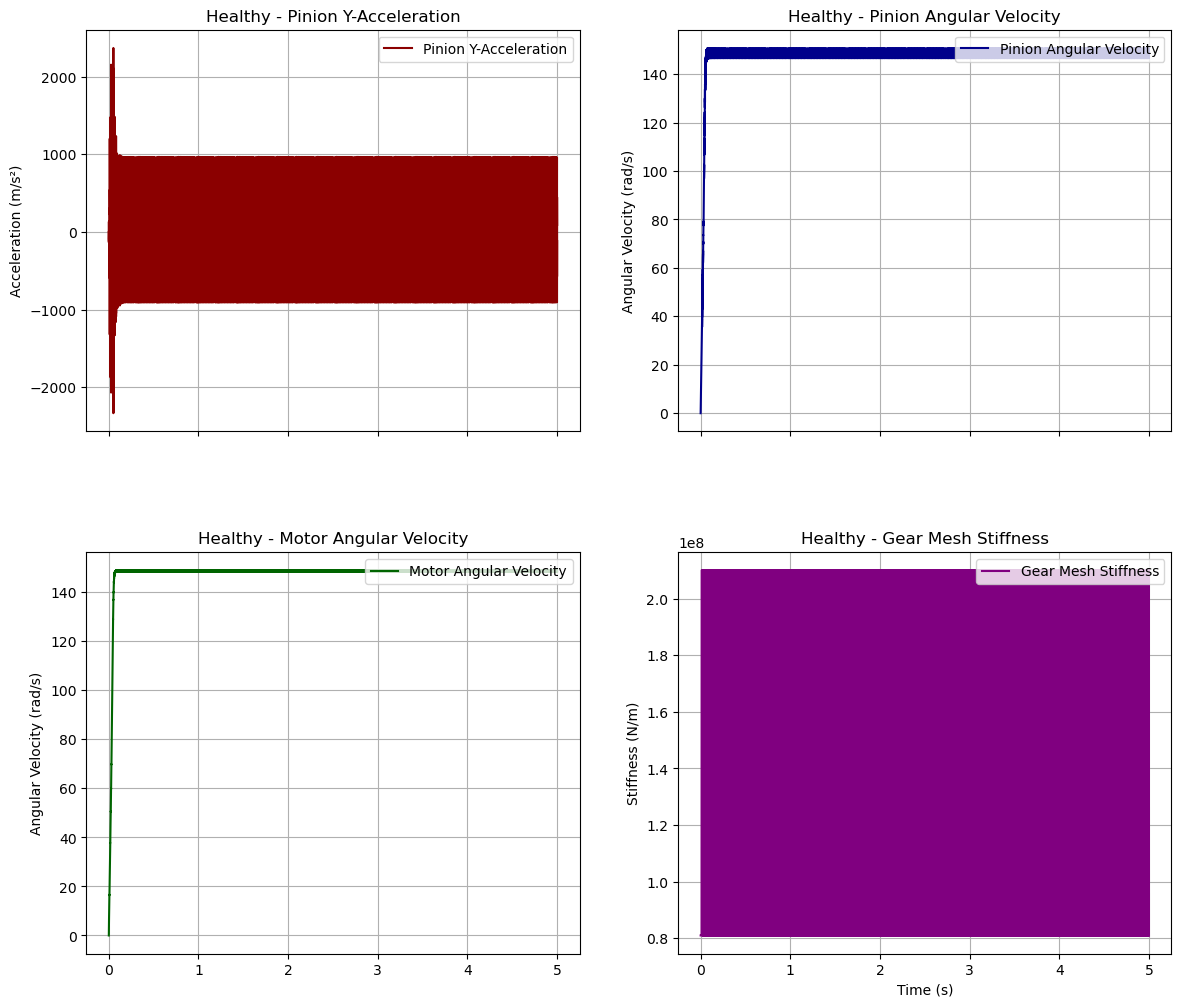

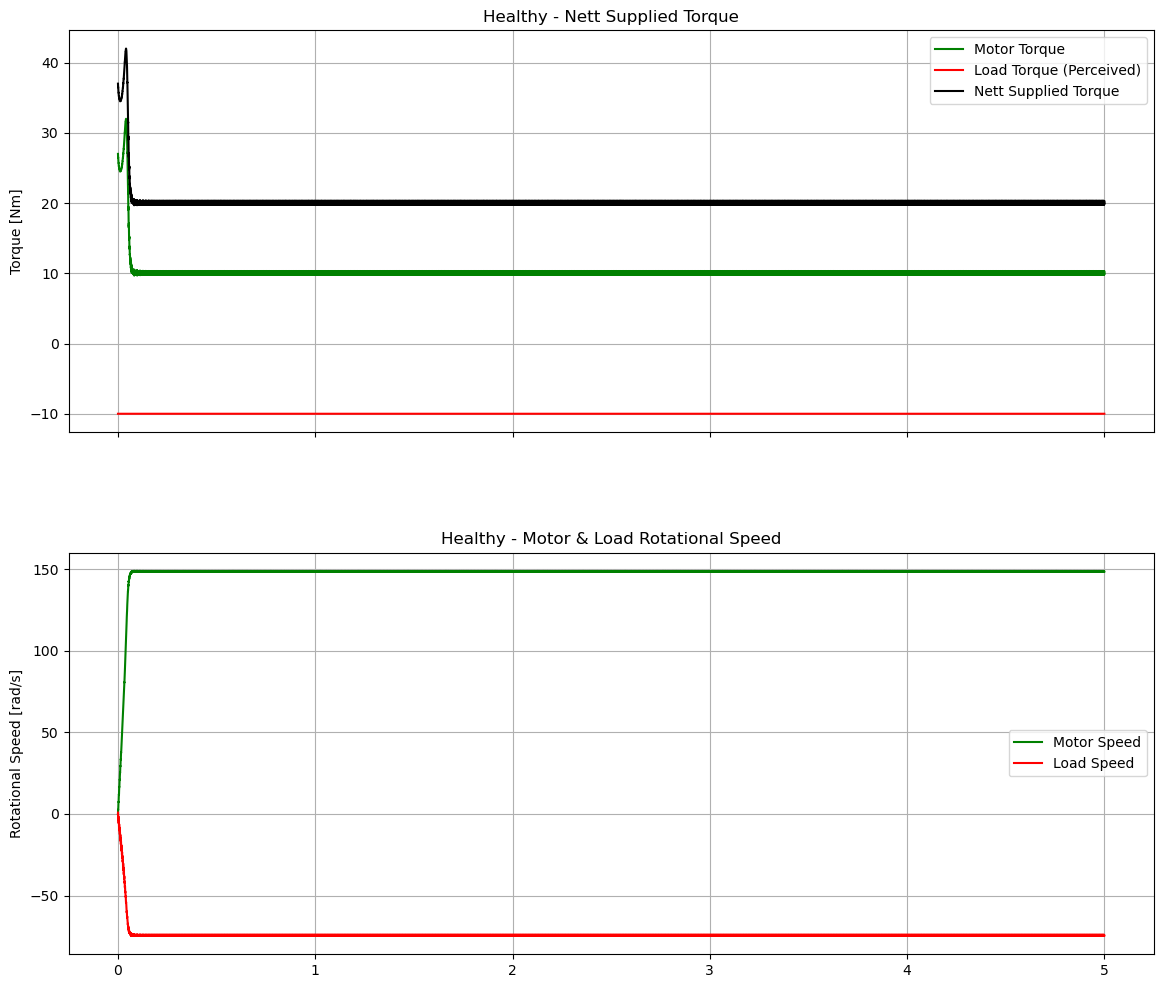

In [5]:
def time_to_freq(time, vibration):
    from scipy.fft import fft, fftfreq
    
    dt = time[1] - time[0]
    Fs = 1/dt
    N = len(vibration)
    A = fft(vibration)
    freq = fftfreq(N, dt)
    
    return (A, freq)

def plot_gearbox_signals(data, title_prefix="Healthy", save_fig=False):
    import matplotlib.pyplot as plt

    time = data["time"]
    a = data["acceleration"]
    v = data["velocity"]
    k_gm = data["gear_mesh_stiffness"]
    F_store = data["force"]
    net_supplied_torques = data["net_supplied_torques"]

    # Direct Output Signals
    fig1, ax1 = plt.subplots(2, 2, figsize=(14, 12), sharex=True)
    fig1.subplots_adjust(hspace=0.3)

    ax1[0,0].plot(time, a[:, 1], label='Pinion Y-Acceleration', color='darkred')
    ax1[0,0].set_ylabel("Acceleration (m/s²)")
    ax1[0,0].legend(loc="upper right")
    ax1[0,0].set_title(f"{title_prefix} - Pinion Y-Acceleration")
    ax1[0,0].grid()

    ax1[0,1].plot(time, v[:, 3], label='Pinion Angular Velocity', color='darkblue')
    ax1[0,1].set_ylabel("Angular Velocity (rad/s)")
    ax1[0,1].legend(loc="upper right")
    ax1[0,1].set_title(f"{title_prefix} - Pinion Angular Velocity")
    ax1[0,1].grid()

    ax1[1,0].plot(time, v[:, 2], label='Motor Angular Velocity', color='darkgreen')
    ax1[1,0].set_ylabel("Angular Velocity (rad/s)")
    ax1[1,0].legend(loc="upper right")
    ax1[1,0].set_title(f"{title_prefix} - Motor Angular Velocity")
    ax1[1,0].grid()

    ax1[1,1].plot(time, k_gm, label='Gear Mesh Stiffness', color='purple')
    ax1[1,1].set_ylabel("Stiffness (N/m)")
    ax1[1,1].set_xlabel("Time (s)")
    ax1[1,1].legend(loc="upper right")
    ax1[1,1].set_title(f"{title_prefix} - Gear Mesh Stiffness")
    ax1[1,1].grid()

    if save_fig:
        fig1.savefig(f"{title_prefix}_gearbox_signals.png", dpi=300, bbox_inches='tight')

    # Torque, Rotational Speed, Gear Meshing Stiffness
    fig2, ax = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    fig2.subplots_adjust(hspace=0.3)

    # Torque Plot
    ax[0].plot(time, F_store[:, 2], color='g', label="Motor Torque")
    ax[0].plot(time, -F_store[:, 6] / 2, color='r', label="Load Torque (Perceived)")
    ax[0].plot(time, net_supplied_torques, color='k', label="Nett Supplied Torque")
    ax[0].set_title(f"{title_prefix} - Nett Supplied Torque")
    ax[0].set_ylabel("Torque [Nm]")
    ax[0].grid()
    ax[0].legend()

    # Rotational Speed Plot
    ax[1].plot(time, v[:, 2], color='g', label="Motor Speed")
    ax[1].plot(time, v[:, 6], color='r', label="Load Speed")
    ax[1].set_title(f"{title_prefix} - Motor & Load Rotational Speed")
    ax[1].set_ylabel("Rotational Speed [rad/s]")
    ax[1].grid()
    ax[1].legend()

    if save_fig:
        fig2.savefig(f"{title_prefix}_torque_speed_stiffness.png", dpi=300, bbox_inches='tight')

    plt.show()
    
plot_gearbox_signals(healthy_data, title_prefix="Healthy")

In [6]:
def test(variable):

    if variable == 0:
        return ("Variable is not 1")
    elif variable == 1:
        return ("Variable is 1")